## The Corona Virus.


In [1]:
import numpy as numpy
import math

from astropy.io import ascii

from BayesicFitting import NestedSampler
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
from BayesicFitting import Tools
import matplotlib.pyplot as plt

from BayesicFitting import SplinesDynamicModel

In [2]:
%matplotlib inline
#%matplotlib osx

We have mortality percentages of the corona virus for 10 age groups between 0 and 100.<br>
They have mortalities of :<br>
0.0 0.0 0.0 0.3 0.5 1.1 3.9 13.4 20.6 23.1

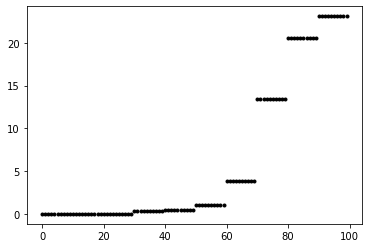

In [3]:
ky = numpy.arange( 100, dtype=int )
py = numpy.asarray( [0,0,0,0.3,0.5,1.1,3.9,13.4,20.6,23.1] )

perc = py[ ky // 10 ]
year = numpy.asarray( ky, dtype=float )

plt.plot( year, perc, 'k.' )
plt.show()

As I am 70 myself and I dont believe that the mortality suddenly jumps from 3.9% to 13.4% on the 70th birthday, I would like to know what my chances are when the virus attacks.

We need a model to fit to the data. As continuity is important we turn to a splines model.

At first we try a splinesmodel with a fixed number of knots. In this case 3 as there is not much curvature in the problem. 

In [4]:
# We need initial knot settings
knots =[0, 50, 100]

mdl = SplinesDynamicModel( knots=knots, dynamic=False, modifiable=True )
mdl.setLimits( lowLimits=[-20.0,-20.0], highLimits=[+100.0,100.0] )


Fit all parameters of
  ModBasicSplines of order 3 with 3 knots.
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine  StructureEngine
>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


>

>

>

>

>

>


Iteration   logZ        H     LowL     npar    parameters
    5586      -201.     27.9      -169.      6 
[   -1.130    4.912  -13.780   28.419   21.605    1.318]
Engines              success     reject     failed       best      calls
GalileanEngine         39112      14422       8940          0       5587
ChordEngine            39033      42716          0          0       5587
StructureEngine         1528          0       4059          0       5587
Calls to LogL         149810   to dLogL      14422
Samples        5686
Evidence       -87.396 +-      0.230


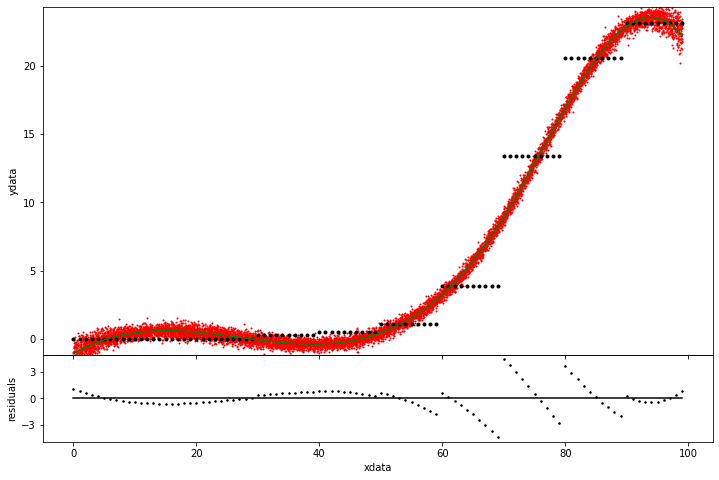

In [5]:
ns = NestedSampler( year, mdl, perc, seed=1234 )
ns.distribution.setLimits( [0.01,100] )
#ns.verbose = 2
evid = ns.sample( plot=True )



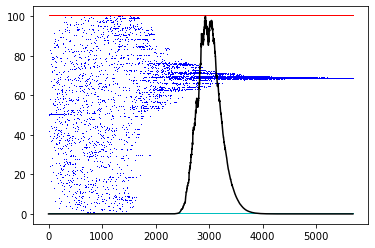

In [6]:
## plot the evolution of the knot locations and of the sample weights

sl = ns.samples
cc = ['k,', 'b,', 'r,', 'g,', 'c,', 'm,']
mxk = 5
ka = numpy.zeros( ( mxk, len( sl ) ), dtype=float )
plt.figure( "knots" )
for k,s in enumerate( sl ) :
    n = len( s.model.knots )
    ka[:n,k] = s.model.knots
for j in range( mxk ) :
    plt.plot( ka[j,:], cc[j%6] )
wgts = sl.getWeightEvolution()
maxw = max( wgts )
plt.plot( 100 * wgts / maxw, 'k-' )
plt.show()



In the model some points drop below zero. That of course is impossible for a mortality rate. By definition the mortality is larger or equal to zero. 

We could enforce positivity by having all parameter >= 0, so that all spline blobs which sum to the model result, are also positive. However that is too much, we need the sum to be positive, everywhere. The individual spline blobs we dont care about.

Lets enforce positivity in our model results with a constrain method.

In [7]:
def constrainPos( logL, problem, allpars, lowLhood ):
    xx = numpy.arange( 101, dtype=float )
    yy = problem.model.result( xx, allpars[:-1] )
    if numpy.any( yy < 0 ):
        return lowLhood - 1       ## assign to the logLikelhood to avoid this area 
    else :
        return logL               ## return unchanged logLikelihood
    

Fit all parameters of
  ModBasicSplines of order 3 with 3 knots.
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine  StructureEngine
>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


>

>

>

>

>

>

>

>

>

>


Iteration   logZ        H     LowL     npar    parameters
    5903      -208.     29.5      -174.      6 
[    0.000    4.147  -11.968   28.202   21.545    1.372]
Engines              success     reject     failed       best      calls
GalileanEngine         39657      13196      15700          0       5949
ChordEngine            41624      99617          0          0       5949
StructureEngine         1542          0       4407          0       5949
Calls to LogL         215743   to dLogL      13196
Samples        6003
Evidence       -90.149 +-      0.236


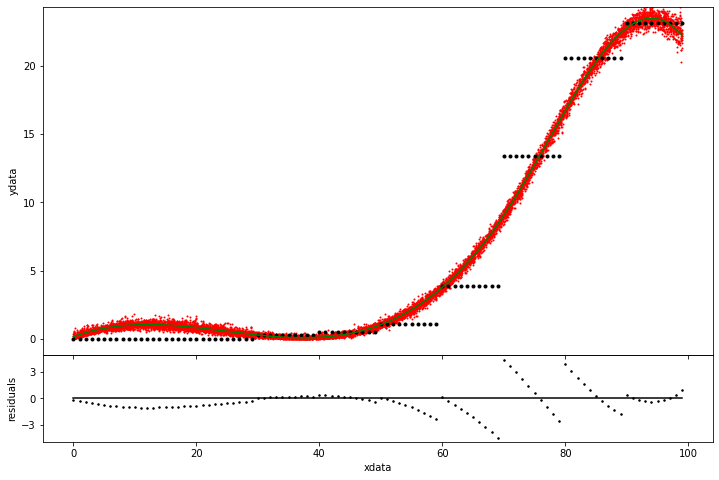

In [8]:
ns = NestedSampler( year, mdl, perc, seed=1234 )
ns.distribution.setLimits( [0.01,100.0] )
#ns.verbose = 2
ns.distribution.constrain = constrainPos
evid = ns.sample( plot=True )


Although we lost our negative mortality rates, the model is not very satisfying. A bump at 10 years for which there is no evidence in the data at all; too slow rise between 50 and 70; and a top at 95. Moreover the log evidence decreased from -87.4 to -90.1, almost 3 (log)points, which means that this model is almost 1000 times less likely.

Lets see if the model can find the number of knots and their locations by itself. We define a dynamic, modifiable basic splines model.

In [9]:
# We need initial knot settings
knots =[0, 50, 100]

mdl = SplinesDynamicModel( knots=knots, maxKnots=5 )
mdl.setLimits( lowLimits=[-10.0,-10.0], highLimits=[+100.0,100.0] )


Fit all parameters of
  DynModBasicSplines of order 3 with 3 knots.
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  BirthEngine  DeathEngine  StructureEngine
>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>

>


Iteration   logZ        H     LowL     npar    parameters
    6994      -197.     35.0      -152.      8 
[    0.017    0.778   -2.087    4.210   20.963   22.818   23.383    1.111]
Engines              success     reject     failed       best      calls
GalileanEngine         48905      15933      17269          0       7088
BirthEngine              573      10579        948          0       7088
DeathEngine              430       4097       2561          0       7088
StructureEngine         8562          0       9218          0       7088
Calls to LogL         109999   to dLogL      15933
Samples        7094
Evidence       -85.422 +-      0.257


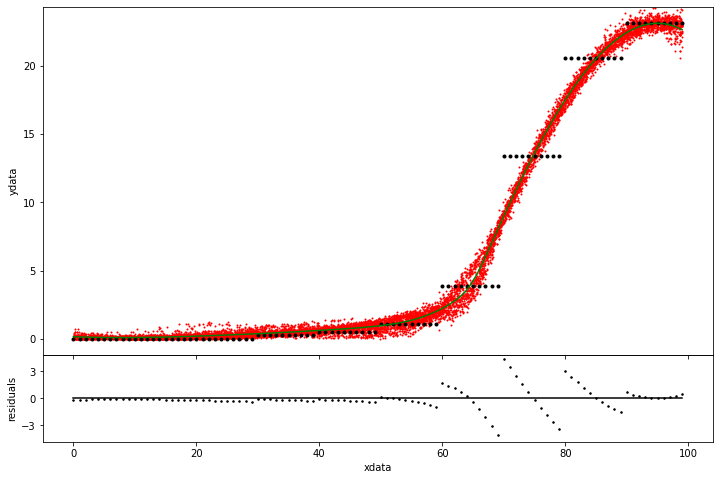

In [10]:
eng = ["galilean", "birth", "death", "struct"]
ns = NestedSampler( year, mdl, perc, engines=eng, seed=1234 )
ns.distribution.setLimits( [0.01,100] )
ns.distribution.constrain = constrainPos
#ns.verbose = 2
evid = ns.sample( plot=True )



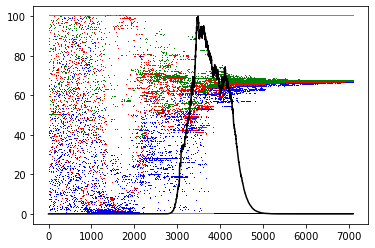

In [11]:
## plot the evolution of the knot locations and of the sample weights

sl = ns.samples
cc = ['k,', 'b,', 'r,', 'g,', 'c,', 'm,']
mxk = 5
ka = numpy.zeros( ( mxk, len( sl ) ), dtype=float )
for k,s in enumerate( sl ) :
    n = len( s.model.knots )
    ka[:n,k] = s.model.knots
for j in range( mxk ) :
    plt.plot( ka[j,:], cc[j%6] )
wgts = sl.getWeightEvolution()
maxw = max( wgts )
plt.plot( 100 * wgts / maxw, 'k-' )
plt.show()




This model looks a lot better. Also the evidence is better by 2 points, from -87.4 to -85.4.

Back to my original question: What is my mortality at the age of 70.

In [12]:
rate = sl.average( 70 )
stdv = sl.error
print( "mortality %6.2f +- %6.2f" % ( rate[0], stdv[0] ) )

mortality   8.49 +-   0.52
